In [1]:
#Importando as bibliotecas
import pandas as pd
from zipfile import ZipFile
import seaborn as sns
from statsmodels.stats.weightstats import zconfint
from scipy.stats import normaltest
from scipy.stats import ranksums

#Lendo a base de dados
caminho = "/content/drive/MyDrive/Bootcamp Alura/Módulo 03/Arquivos/dados/PeNSE_2015_AMOSTRA2.zip"
zip = ZipFile(caminho)
caminho_pasta_zipada = zip.namelist()[1]

dados = pd.read_csv(zip.open(caminho_pasta_zipada), sep = ";", thousands = ".", decimal = ",")
dados.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,ANOPESQ,PAIS,REGEOGR,VB00004,VB01001,VB01002,VB01003,VB01004,VB01005,VB01006,VB01007,VB01008A,VB01010A,VB01011,VB01012,VB01013,VB01014,VB01015A,VB01016,VB01017,VB01018,VB01019,VB01020A,VB01021,VB01022,VB01023,VB01024,VB01025,VB01026,VB02001,VB02002,VB02004A,VB02010,VB02011,VB02013,VB02017A,VB02018A,VB02019A,VB02020A,VB02021,...,VB11005,VB11006,VB11007,VB12001,VB12002,VB12003,VB13001,VB13002A,VB13004A,VB13005,VB13006,VB13007,VB13008,VB13009,VB14001,VB14002,VB16001A01,VB16001A02,VB16001A03,VB16001A04,VB16001A05,VB16001A06,VB16001A07,VB16001A08,VB17001,VB17002,VB17003,VB17004,VB17005,VB17006,ESTRATO_EXP,ESTRATOGEOREG,PESO,V0006,V0007,V0008,V0041,aluno,escola,turma
0,2015,76,1,1,2,1,13,7,7,1,2,7,3,2,-1,1,1,1,1,1,2,4,2,4,1,2,2,5,1,8,3,4,3,6,6,1,6,1,-1,2,...,2,1,2,1,1,4,2,-1,3,1,1,-1,1,1,2,2,1,2,2,2,2,2,2,2,371.0,1570.0,37.1,157.0,2,1,1223,1,299.735235,1,2,4,1,1,1,296
1,2015,76,1,1,2,1,14,4,7,1,1,7,3,2,-1,1,1,1,1,1,2,2,2,4,1,2,2,5,3,8,2,1,8,8,6,1,1,5,-1,2,...,2,3,2,4,4,4,1,2,3,3,1,-1,1,1,2,2,2,2,2,1,2,2,2,2,502.0,1520.0,50.2,152.0,2,2,1223,1,355.170081,1,2,4,1,2,1,296
2,2015,76,1,1,1,4,13,6,7,1,1,5,5,2,-1,2,1,1,1,1,2,3,1,4,1,2,2,5,3,2,3,1,8,2,8,1,1,5,5,1,...,2,1,2,1,2,3,1,2,1,2,5,99,1,-1,2,2,1,1,1,1,1,1,1,1,482.0,1614.0,48.2,161.4,2,2,1223,1,299.735235,1,2,4,1,3,1,296
3,2015,76,1,1,1,1,14,6,7,1,1,7,4,2,-1,1,1,1,1,1,2,4,2,4,1,2,2,6,3,2,4,1,3,2,7,1,5,1,-1,2,...,2,1,2,2,2,4,1,10,3,1,2,-1,1,-1,2,2,1,2,2,2,1,2,2,2,694.0,1725.0,69.4,172.5,2,3,1223,1,355.170081,1,2,4,1,4,1,296
4,2015,76,1,1,1,1,13,9,7,1,2,5,4,2,-1,2,1,1,1,1,2,5,1,4,1,2,2,6,5,6,3,5,2,6,2,1,5,1,5,1,...,2,1,4,2,2,4,1,3,2,2,2,13,1,-1,1,2,1,1,1,1,1,1,1,1,789.0,1675.0,78.9,167.5,2,4,1223,1,299.735235,1,2,4,1,5,1,296


**Cálculo do IMC:**
\begin{equation}
IMC =\dfrac{PESO}{ALTURA ^2}
\end{equation}
<br>

In [2]:
#Calculando o IMC
#É necessário converter a altura de cm para m
dados["IMC"] = dados["VB17003"] / ((dados["VB17004"]/100)**2)
dados["IMC"]

0        15.051321
1        21.727839
2        18.502907
3        23.322831
4        28.122076
           ...    
16551    20.113223
16552    17.930782
16553    23.968489
16554    18.995343
16555    23.303246
Name: IMC, Length: 16556, dtype: float64

**Classificação do IMC:**
- Menor que 18,5 - Abaixo do peso
- Entre 18,5 e 24,9 - Peso normal
- Entre 25 e 29,9 - Sobrepeso (acima do peso desejado)
- Igual ou acima de 30 - Obesidade

http://bvsms.saude.gov.br/bvs/dicas/215_obesidade.html

In [3]:
#Criando as classes do IMC

'''
pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)

Bin values into discrete intervals.
Use cut when you need to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable 
For example, cut could convert ages to groups of age ranges. Supports binning into an equal number of bins, or a pre-specified array of bins

include_lowestbool, default False
Whether the first interval should be left-inclusive or not
'''

classes = [0, 18.5, 25, 30, 60]
labels = ["Abaixo do peso", "Peso normal", "Sobrepeso", "Obesidade"]

dados["CLASSE_IMC"] = pd.cut(x = dados["IMC"], bins = classes, labels = labels, include_lowest = True)

dados[["IMC", "CLASSE_IMC"]]

,IMC,CLASSE_IMC
0,15.051321,Abaixo do peso
1,21.727839,Peso normal
2,18.502907,Peso normal
3,23.322831,Peso normal
4,28.122076,Sobrepeso
...,...,...
16551,20.113223,Peso normal
16552,17.930782,Abaixo do peso
16553,23.968489,Peso normal
16554,18.995343,Peso normal


In [4]:
#Lendo os dados do Dicionário PeNSE
dicionario = pd.read_excel("/content/drive/MyDrive/Bootcamp Alura/Módulo 03/Arquivos/dados/Dicionario_PENSE_Microdados_AMOSTRA2.xls")

In [5]:
#Criando a função para criar um dicionário com as respostas
def cria_dicionario_respostas(cod_pergunta: str, dicionario = dicionario):
  '''
  Esta função cria um dicionario com as respostas a partir do código da pergunta

  Parâmetros: 
    cod_pergunta: string com o código da pergunta
    dicionario: DataFrame com os dados do arquivo "Dicionario_PENSE_Microdados_AMOSTRA2.xls"
  
  Retorna:
   dicionario_respostas: dicionário com as váriaveis (keys) e as alternativas de resposta (values)
   pergunta: string com texto da pergunta
  '''

  #Fazendo a query
  busca = dicionario.query(f"VARIÁVEL == '{cod_pergunta}'")

  #Selecionando o índice da pergunta no dicionário
  indice_pergunta = (busca.index).tolist()[0]
  
  #Guardando o texto da pergunta
  #df.iloc[<linhas>, <colunas>]
  pergunta = dicionario.iloc[indice_pergunta, 1]

  #Criando um dicionário para as respostas possíveis
  dicionario_respostas = {}

  #Enquanto nnão encontro o código da próxima perguntar
  indice = indice_pergunta + 1

  while str(dicionario.loc[indice]["VARIÁVEL"]).startswith("VB") != True:

    #Adicionando as variáveis e as alternativas de resposta ao dicionário
    nova_linha = {int(dicionario.loc[indice]["VARIÁVEL"]) : dicionario.loc[indice]["QUESTIONÁRIO DO ALUNO"]}

    #Atualizando o dicionário com a nova linha
    dicionario_respostas.update(nova_linha)

    indice = indice + 1
  
  return dicionario_respostas, pergunta

In [6]:
#Criando uma função para plotar o histograma comparando duas variáveis
def compara_histograma(cod_pergunta: str, pergunta: str, compara: str, dados = dados):

  '''
  Esta função cria um histograma a partir do código da pergunta, além disso plota o desvio padrão, a média, 
  a moda e a mediana
  
  Parâmetros:
    cod_pergunta: string com o código da pergunta
    dados: DataFrame com os dados do arquivo "PENSE_AMOSTRA2_ALUNO.CSV"
    pergunta: string com a pergunta
    compara: string com a variável a ser comparada
 '''

  #Plotando o histograma
  ax = sns.histplot(x = cod_pergunta, data = dados, kde = True, hue = compara)
  ax.figure.set_size_inches(12,6)
  ax.set_title("Distribuição de frequência", fontsize=16)
  ax.set_xlabel(f"{pergunta}", fontsize=12)
  ax.set_ylabel("")

  ax;

In [7]:
#Função para arredondar os valores de uma tupla
def arredonda_tupla(tupla):
  return tuple([round(x,2) if isinstance(x, float) else x for x in tupla])

**Objetivo: observar algum indício de transtorno dismórfico corporal (TDC), que se caracteriza pela percepção alterada de si mesmo diante do espelho: quando o que a pessoa enxerga no espelho não condiz com a realidade.**

https://www.cellerafarma.com.br/bem-estar/disturbio-de-imagem-entenda-o-que-e

Homens e mulheres são vítimas do transtorno em igual proporção.

Desta forma, não será feita distinção entre os sexos feminino e masculino.

In [8]:
#Calculando a frequência cruzando a Classificação do IMC e a pergunta "VB11001: Quanto ao seu corpo, você se considera:"

#Criando os dicionários
respostas_indices = cria_dicionario_respostas("VB11001")[0]
pergunta_indices = cria_dicionario_respostas("VB11001")[1]

frequencia_cruzada = pd.crosstab(dados["VB11001"], dados["CLASSE_IMC"], normalize = True) * 100
frequencia_cruzada.rename(index = respostas_indices, inplace = True)
frequencia_cruzada.rename_axis(pergunta_indices, axis=0, inplace = True)
frequencia_cruzada.rename_axis("Classificação do IMC:", axis=1, inplace = True)
frequencia_cruzada.round(2)

Classificação do IMC:,Abaixo do peso,Peso normal,Sobrepeso,Obesidade
"Quanto ao seu corpo, você se considera:",,,,
Muito magro(a),3.84,1.79,0.10,0.02
Magro(a),11.09,8.29,0.25,0.07
Normal,13.84,35.03,3.94,0.48
Gordo(a),0.75,8.94,5.48,2.65
Muito Gordo(a),0.21,0.90,0.79,0.58
Não informado,0.32,0.54,0.07,0.02


Analisando essa primeira pergunta, não é possível observar grandes distorções em relação à forma como o estudante se enxerga.

O único ponto a observar: 8.94% dos estudantes tem peso considerado normal e se consideram gordos(as).

In [9]:
#Calculando a frequência cruzando a Classificação do IMC e a pergunta "VB11002: O que você está fazendo em relação a seu peso?"

#Criando os dicionários
respostas_indices = cria_dicionario_respostas("VB11002")[0]
pergunta_indices = cria_dicionario_respostas("VB11002")[1]

frequencia_cruzada = pd.crosstab(dados["VB11002"], dados["CLASSE_IMC"], normalize = True) * 100
frequencia_cruzada.rename(index = respostas_indices, inplace = True)
frequencia_cruzada.rename_axis(pergunta_indices, axis=0, inplace = True)
frequencia_cruzada.rename_axis("Classificação do IMC:", axis=1, inplace = True)
frequencia_cruzada.round(2)

Classificação do IMC:,Abaixo do peso,Peso normal,Sobrepeso,Obesidade
O que você está fazendo em relação a seu peso?,,,,
Não estou fazendo nada,13.25,20.69,2.57,0.76
Estou tentando perder peso,2.00,16.69,6.80,2.83
Estou tentando ganhar peso,9.62,6.27,0.22,0.04
Estou tentando manter o mesmo peso,4.83,11.27,0.97,0.19
Não informado,0.35,0.57,0.07,0.01


Já analisando o que os estudantes estão fazendo em relação ao peso, foi observado que:

|| Abaixo do peso  | Peso normal  |
|-|:-:|:--:|
|**Não estou fazendo nada**|13.25%|20.69%|
|**Estou tentando perder peso**|2.00%|16.69%|
|**Estou tentando ganhar peso**|9.62%|6.27%|
|**Estou tentando manter o mesmo peso**|4.83%|11.27%|
>
Ou seja, é possível identificar alguns comportamentos preocupantes.

O transtorno dismórfico corporal geralmente não vem sozinho: cerca de 32% das pessoas que sofrem com o distúrbio de imagem sofrem de anorexia ou bulimia.

In [10]:
#Calculando a frequência cruzando a Classificação do IMC e a pergunta "VB11003: NOS ÚLTIMOS 30 DIAS, 
#você vomitou ou tomou laxantes para perder peso ou evitar ganhar peso?"

#Criando os dicionários
respostas_indices = cria_dicionario_respostas("VB11003")[0]

frequencia_cruzada = pd.crosstab(dados["VB11003"], dados["CLASSE_IMC"], normalize = True) * 100
frequencia_cruzada.rename(index = respostas_indices, inplace = True)
frequencia_cruzada.rename_axis("Classificação do IMC:", axis=1, inplace = True)
frequencia_cruzada.round(2)

Classificação do IMC:,Abaixo do peso,Peso normal,Sobrepeso,Obesidade
VB11003,,,,
Sim,2.10,3.98,1.15,0.40
Não,27.53,50.92,9.40,3.40
Não informado,0.42,0.60,0.08,0.02


Felizmente, 91.25% dos estudantes responderam "Não" para pergunta acima.

Ainda assim, é importante ressaltar que dentre os estudantes que responderam "Sim", a maior porcentagem está "Abaixo do Peso" ou tem "Peso Normal".

A origem do transtorno é neuroquímica, mas o **fator ambiental** exerce bastante influência, principalmente na fase da adolescência, onde o cérebro está em formação.

In [11]:
#Calculando a frequência cruzando a Classificação do IMC e a pergunta "VB07008: NOS ÚLTIMOS 30 DIAS, 
#qual o motivo/causa de seus colegas terem te esculachado, zombado, zoado, caçoado, mangado, intimidado ou humilhado?"

#Criando os dicionários
respostas_indices = cria_dicionario_respostas("VB07008")[0]

frequencia_cruzada = pd.crosstab(dados["VB07008"], dados["CLASSE_IMC"], normalize = "columns") * 100
frequencia_cruzada.rename(index = respostas_indices, inplace = True)
frequencia_cruzada.rename_axis("Classificação do IMC:", axis=1, inplace = True)
frequencia_cruzada.round(2)

Classificação do IMC:,Abaixo do peso,Peso normal,Sobrepeso,Obesidade
VB07008,,,,
Pulo no questionário,54.07,57.27,55.06,51.97
A minha cor ou raça,2.77,2.38,2.10,1.42
A minha religião,1.65,1.44,1.25,0.79
A aparência do meu rosto,5.23,4.35,2.27,0.79
A aparência do meu corpo,6.31,3.89,14.83,28.12
A minha orientação sexual,0.90,1.00,1.02,0.79
A minha região de origem,0.74,0.74,0.68,0.32
Outros motivos/causas,27.82,28.45,22.33,15.48
Não informado,0.50,0.48,0.45,0.32


Ao normalizar pelas colunas, é possível observar que estudantes em todas as classificações de IMC sofrem bullying devido à aparência do seu corpo.

Especialmente entre estudantes com sobrepeso e obesidade, essa motivação é frequente.

|  | Abaixo do peso | Peso normal | Sobrepeso | Obesidade |
|-|:-:|:-:|:-:|:-:|
| **A aparência do meu corpo** | 6.31% | 3.89% |  14.83% |  28.12% |

**Changing Pandas Crosstab Aggregation**

If you wanted to change the type of aggregation used, you can apply the aggfunc parameter. To use the aggfunc parameter requires the values parameter to also be passed.

In [12]:
#Calculando a frequência cruzando o Sexo e a pergunta "VB11001: Quanto ao seu corpo, você se considera:" 
#e agregando pelo valor mínimo do IMC

#Criando os dicionários
respostas_indices = cria_dicionario_respostas("VB11001")[0]
pergunta_indices = cria_dicionario_respostas("VB11001")[1]

respostas_colunas = cria_dicionario_respostas("VB01001")[0]
pergunta_colunas = cria_dicionario_respostas("VB01001")[1]

frequencia_cruzada = pd.crosstab(dados["VB11001"], dados["VB01001"], values=dados["IMC"], aggfunc="min").round(2) 
frequencia_cruzada.rename(index = respostas_indices, inplace = True)
frequencia_cruzada.rename(columns = respostas_colunas, inplace = True)
frequencia_cruzada.rename_axis(pergunta_indices, axis=0, inplace = True)
frequencia_cruzada.rename_axis(pergunta_colunas, axis=1, inplace = True)
frequencia_cruzada

Qual é o seu sexo?,Masculino,Feminino
"Quanto ao seu corpo, você se considera:",,
Muito magro(a),12.88,13.00
Magro(a),11.90,12.17
Normal,12.48,12.32
Gordo(a),0.40,13.94
Muito Gordo(a),13.89,11.14
Não informado,13.63,13.92


Analisando o IMC mínimo em cada categoria e nos sexos feminino e masculino, infelizmente, algum erro na coleta de dados resultou em um IMC de 0.40, que não é um valor possível.

Sendo assim, esse valor será desconsiderado.

In [13]:
dados.loc[dados["IMC"] < 10]

,ANOPESQ,PAIS,REGEOGR,VB00004,VB01001,VB01002,VB01003,VB01004,VB01005,VB01006,VB01007,VB01008A,VB01010A,VB01011,VB01012,VB01013,VB01014,VB01015A,VB01016,VB01017,VB01018,VB01019,VB01020A,VB01021,VB01022,VB01023,VB01024,VB01025,VB01026,VB02001,VB02002,VB02004A,VB02010,VB02011,VB02013,VB02017A,VB02018A,VB02019A,VB02020A,VB02021,...,VB11007,VB12001,VB12002,VB12003,VB13001,VB13002A,VB13004A,VB13005,VB13006,VB13007,VB13008,VB13009,VB14001,VB14002,VB16001A01,VB16001A02,VB16001A03,VB16001A04,VB16001A05,VB16001A06,VB16001A07,VB16001A08,VB17001,VB17002,VB17003,VB17004,VB17005,VB17006,ESTRATO_EXP,ESTRATOGEOREG,PESO,V0006,V0007,V0008,V0041,aluno,escola,turma,IMC,CLASSE_IMC
15673,2015,76,5,1,1,4,12,3,9,1,1,8,4,1,1,2,1,1,1,1,1,2,2,2,3,1,2,2,3,8,1,8,1,4,3,1,6,1,1,1,...,1,1,3,4,1,2,1,2,2,1,1,-1,1,1,2,2,2,1,2,2,2,2,408.0,1418.0,0.8,141.8,2,2,5121,5,313.160012,1,1,2,-1,15674,355,317,0.397867,Abaixo do peso


In [14]:
dados.loc[15673][["VB17001", "VB17002", "IMC"]]

VB17001         408
VB17002        1418
IMC        0.397867
Name: 15673, dtype: object

In [15]:
dados = dados.drop([15673], axis=0)

Uma nova análise será feita considerando a quantidade de estudantes com IMC menor que 18.5 em cada categoria e nos sexos feminino e masculino.

In [16]:
#Calculando a frequência cruzando o Sexo e a pergunta "VB11001: Quanto ao seu corpo, você se considera:" 
#Agregando pela contagem de IMC menor que 18,5

#Criando os dicionários
respostas_indices = cria_dicionario_respostas("VB11001")[0]
pergunta_indices = cria_dicionario_respostas("VB11001")[1]

respostas_colunas = cria_dicionario_respostas("VB01001")[0]
pergunta_colunas = cria_dicionario_respostas("VB01001")[1]

frequencia_cruzada = pd.crosstab(dados["VB11001"], dados["VB01001"], values=dados[dados["IMC"]<18.5]["IMC"], 
                                 aggfunc="count", margins=True, margins_name="Total")
frequencia_cruzada.rename(index = respostas_indices, inplace = True)
frequencia_cruzada.rename(columns = respostas_colunas, inplace = True)
frequencia_cruzada.rename_axis(pergunta_indices, axis=0, inplace = True)
frequencia_cruzada.rename_axis(pergunta_colunas, axis=1, inplace = True)
frequencia_cruzada

Qual é o seu sexo?,Masculino,Feminino,Total
"Quanto ao seu corpo, você se considera:",,,
Muito magro(a),249,387,636
Magro(a),967,869,1836
Normal,1300,991,2291
Gordo(a),48,75,123
Muito Gordo(a),17,18,35
Não informado,38,15,53
Total,2619,2355,4974


Na análise acima é possível ver um indício preocupante.

Uma quantidade considerável de estudantes com IMC menor que 18.5, ou seja, abaixo do peso, se considera normal.

|  | Masculino | Feminino |
|-|:-:|:-:|
| **Normal** | 49.64% | 42.08% |

**Índice de Massa Corporal**

In [17]:
#Calculando a média 
media_imc = round(dados["IMC"].groupby(dados["VB01001"]).mean(), 2)

#Calculando o desvio padrão 
desvio_padrao_imc = round(dados["IMC"].groupby(dados["VB01001"]).std(), 2)

#Calculando a variância amostral 
variancia_imc = round(dados["IMC"].groupby(dados["VB01001"]).var(), 2)

#Exibindo as três variáveis em uma tabela
tabela_imc = pd.concat([media_imc, desvio_padrao_imc, variancia_imc], axis=1, keys=["Média", "Desvio Padrão", "Variância"])
tabela_imc = tabela_imc.rename_axis("Sexo", axis="index")
tabela_imc = tabela_imc.rename({1: "Masculino", 2: "Feminino"}, axis="index")
tabela_imc = tabela_imc.rename_axis("IMC", axis="columns")
tabela_imc

IMC,Média,Desvio Padrão,Variância
Sexo,,,
Masculino,20.83,4.27,18.23
Feminino,21.09,4.21,17.72


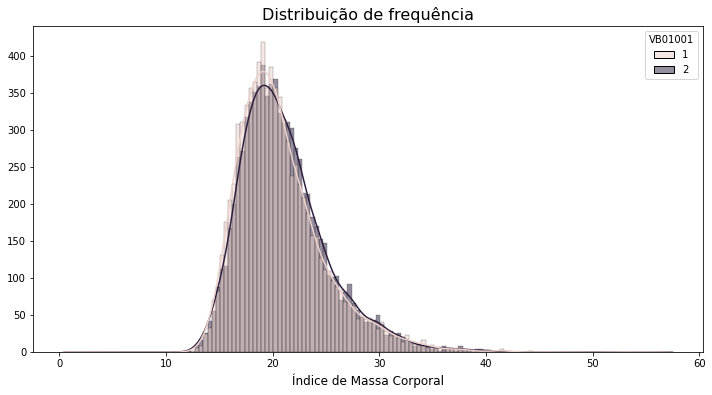

In [18]:
#Plotando o histograma relacionando o IMC e o sexo
compara_histograma("IMC", "Índice de Massa Corporal", "VB01001")

In [19]:
#Calculando o intervalo de confiança do IMC
arredonda_tupla(zconfint(dados["IMC"].to_list()))

(20.89, 21.02)

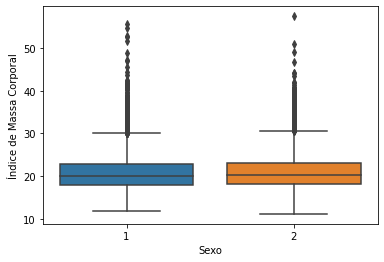

In [20]:
#Plotando o boxplot relacionando o IMC e o sexo
ax = sns.boxplot(x = "VB01001", y = "IMC", data = dados);
ax.set_ylabel("Índice de Massa Corporal")
ax.set_xlabel("Sexo")
ax;

In [21]:
#Definindo as variáveis
distribuicao_imc_m = dados.query("VB01001 == 1")["IMC"]
distribuicao_imc_f = dados.query("VB01001 == 2")["IMC"]

**Normal test**
<br>Hipótese nula: a amostra vem de uma distribuição normal

In [22]:
#Fazendo o teste de normalidade

_, p_value_normaltest_m = normaltest(distribuicao_imc_m)
_, p_value_normaltest_f = normaltest(distribuicao_imc_f)

print(p_value_normaltest_m)
print(p_value_normaltest_f)

0.0
0.0


Sendo p-value menor que 0.05, a hipótese nula é rejeitada: as curvas não configuram uma distribuição normal.
O teste Z não cabe nesse caso.

**Rank-sum test**
<br>Hipótese nula: as duas distribuições são provenientes da mesma distribuição

In [23]:
#Fazendo o rank-sum test
_, p_value = ranksums(distribuicao_imc_m, distribuicao_imc_f)

#Testando a hipótese
p_value < 0.05

True

Sendo p-value menor que 0.05, a hipótese nula é rejeitada: as distribuições são provenientes de distribuições diferentes.

**VB11007: Como você se sente em relação ao seu corpo?**

In [24]:
cria_dicionario_respostas("VB11007")

({1: 'Muito satisfeito(a)',
  2: 'Satisfeito(a)',
  3: 'Indiferente',
  4: 'Insatisfeito(a)',
  5: 'Muito insatisfeito(a)',
  99: 'Não informado'},
 'Como você se sente em relação ao seu corpo?')

In [25]:
#Calculando a frequência cruzando o sexo e a pergunta "VB11007: Como você se sente em relação ao seu corpo?"

#Criando os dicionários
respostas_indices = cria_dicionario_respostas("VB11007")[0]
pergunta_indices = cria_dicionario_respostas("VB11007")[1]

frequencia_cruzada = pd.crosstab(dados["VB11007"], dados["VB01001"], normalize = "columns", colnames=["Sexo"], rownames=[pergunta_indices]) * 100
frequencia_cruzada.rename(index = respostas_indices, inplace = True)
frequencia_cruzada.rename(columns = {1: "Masculino", 2: "Feminino"}, inplace = True)
frequencia_cruzada.round(2)

Sexo,Masculino,Feminino
Como você se sente em relação ao seu corpo?,,
Muito satisfeito(a),32.36,23.29
Satisfeito(a),42.12,41.48
Indiferente,11.47,10.36
Insatisfeito(a),9.49,18.62
Muito insatisfeito(a),3.14,5.49
Não informado,1.44,0.75


Ao normalizar pelas colunas, é possível observar uma maior proporção de estudantes do sexo feminino que se disseram insatisfeitas ou muito insatisfeitas em relação ao corpo.

|  | Masculino | Feminino | 
|-|:-:|:-:|
| **Insatisfeito(a)** | 9.48% | 18.62% | 
| **Muito insatisfeito(a)** | 3.14% | 5.49% |

O inverso também é observado quando se trata de satisfação: houve uma maior proporção de estudantes do sexo masculino que se disseram muito satisfeitos em relação ao corpo.

|  | Masculino | Feminino | 
|-|:-:|:-:|
| **Muito satisfeito(a)** | 32.36% | 23.29% | 

In [26]:
#Calculando a frequência cruzando o Sexo e a pergunta "VB11007: Como você se sente em relação ao seu corpo?" 
#Agregando pela contagem de estudantes insatisfeitos ou muito insatisfeitos em relação ao corpo

#Criando os dicionários
respostas_colunas = cria_dicionario_respostas("VB01001")[0]
pergunta_colunas = cria_dicionario_respostas("VB01001")[1]

frequencia_cruzada = pd.crosstab(dados["CLASSE_IMC"], dados["VB01001"], values=dados.query("VB11007 == 4 or VB11007 == 5")["VB11007"], 
                                 aggfunc="count", normalize="columns") * 100
frequencia_cruzada.rename(columns = respostas_colunas, inplace = True)
frequencia_cruzada.rename_axis("Classificação do IMC:", axis=0, inplace = True)
frequencia_cruzada.rename_axis(pergunta_colunas, axis=1, inplace = True)
frequencia_cruzada.round(2)

Qual é o seu sexo?,Masculino,Feminino
Classificação do IMC:,,
Abaixo do peso,22.28,19.51
Peso normal,47.80,51.40
Sobrepeso,19.41,20.36
Obesidade,10.52,8.73


É importante salientar que a análise feita aqui é bem simplista e desconsidera questões sociais, má alimentação, prática de atividades físicas etc, são apenas indícios de comportamentos preocupantes.